# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Подгружаем библиотеки и загружаем данные

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error,mean_squared_error
from lightgbm import LGBMRegressor
RND_ST = 12345
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
!pip install --upgrade scikit-learn

In [3]:
pth = '/datasets/autos.csv'
if os.path.exists(pth):
    df = pd.read_csv(pth)
else:
    print('Путь не таков')

In [4]:
df['DateCrawled'].sort_values(ascending=False)

90713     2016-04-07 14:36:58
339649    2016-04-07 14:36:56
301030    2016-04-07 14:36:55
53739     2016-04-07 14:36:54
204218    2016-04-07 14:36:53
                 ...         
99885     2016-03-05 14:06:24
324763    2016-03-05 14:06:24
176823    2016-03-05 14:06:24
220583    2016-03-05 14:06:23
329497    2016-03-05 14:06:22
Name: DateCrawled, Length: 354369, dtype: object

Удалим точно не нужные для оценки стоимости автомобиля столбцы

In [5]:
del df['DateCrawled'], df['DateCreated'], df['NumberOfPictures'], df['PostalCode'], df['LastSeen'], df['RegistrationMonth']

Получаем всю неоюходимую информацию

In [6]:
def info_func(df):
    print('Общая информация')
    print('')
    print(df.info())
    print('')
    print(df.describe())
    print('')
    for column in df.columns:
        print('Уникальные значения столбца', column)
        print('')
        print(df[column].unique())
        print('')
    print('Кол-во строк дубликатов')
    print('')
    print(df[df.duplicated()].count().sort_values(ascending=False))
    print('')
    print('Кол-во пропущенных значений')
    print('')
    print(df.isna().sum().sort_values(ascending=False))
    print('')
    print('Процент пропущенных значений')
    print('')
    print((df.isna().sum()/len(df)*100).sort_values(ascending=False))

In [7]:
info_func(df)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB
None

               Price  RegistrationYear          Power      Kilometer
count  354369.000000     354369.000000  354369.000000  354369.000000
mean     4416.656776       2004.234448     110.094337  128211.172535
std      4514.158514         90.227958     

Удаляем дубликаты

In [8]:
df = df.drop_duplicates()

Отсутствующие значения в коропке передач и модели машины - приравняем к значению unknown

In [9]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Model'] = df['Model'].fillna('unknown')

Отсутствующие значения в типе топлива и типе кузова - приравняем к значению other

In [10]:
df['FuelType'] = df['FuelType'].fillna('other')

In [11]:
df['VehicleType']=df['VehicleType'].fillna('other')

Со столбцом с информацией о ремонте двоякая ситуация - с одной стороны это важный параметр и с другой - заполнять его чем попало нельзя.  Следует заменить отсутствующие значения на Nan.

In [12]:
df['Repaired']=df['Repaired'].fillna('no_info')

Рассмотрим поближе лошадиные силы

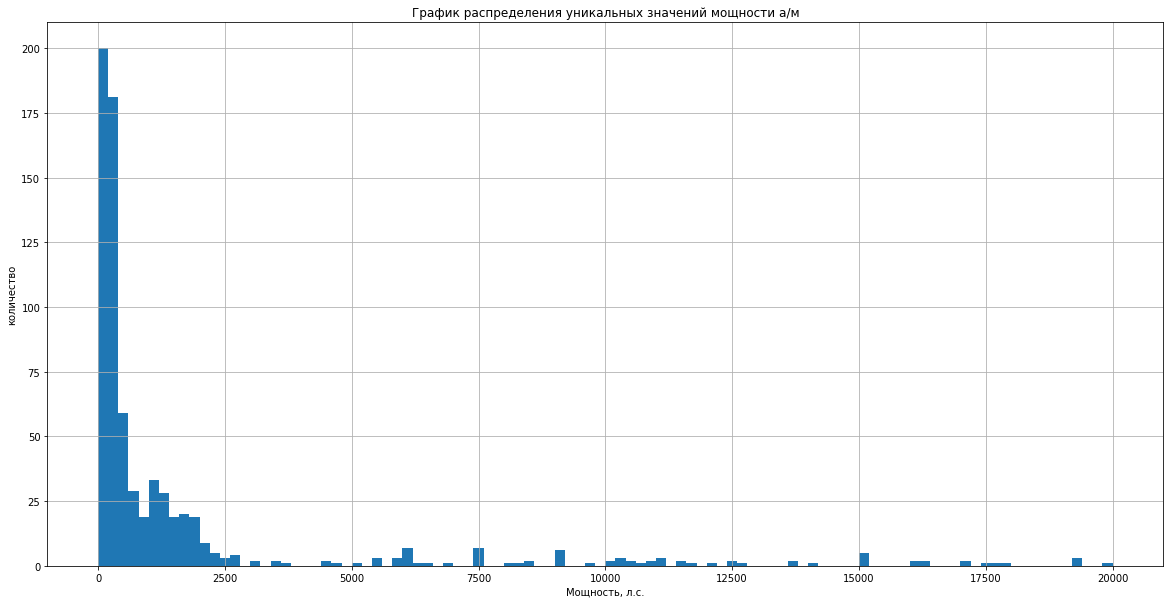

In [13]:
pd.Series(list(df.Power.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(20,10), grid=True, bins=100)
plt.title('График распределения уникальных значений мощности а/м')
plt.ylabel('количество')
plt.xlabel('Мощность, л.с.')
plt.show()

Установим верхний порог лошадиных сил - 1500, и нижний - 10. Больше 1000 идут спорткары (и в целом это допустимо), но больше 1500 - уже какие-то гоночные боллиды. 

In [14]:
df = df.query('Power >= 10 & Power <= 1500')

Рассмотрим поближе год регистрации

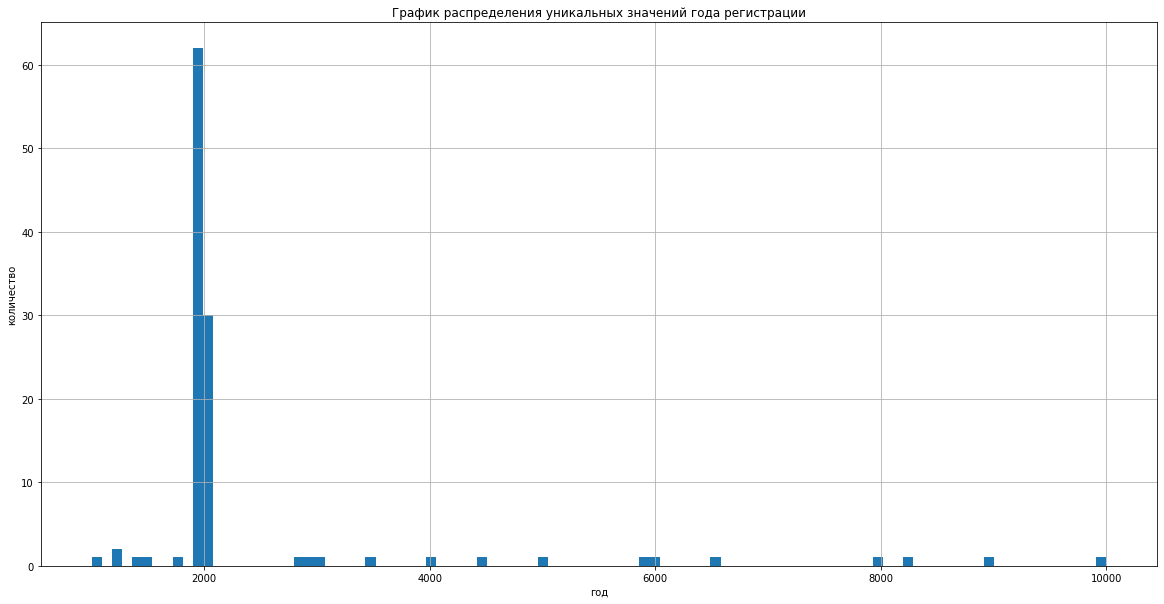

In [15]:
pd.Series(list(df.RegistrationYear.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(20,10), grid=True, bins=100)
plt.title('График распределения уникальных значений года регистрации')
plt.ylabel('количество')
plt.xlabel('год')
plt.show()

Предположим, что первым сайтом в России по продаже авто является auto.ru (владельцем которого теперь кстати является Яндекс). Он был основан в 1996. Тогда 1996 будем нижнем ограничителем, а 2023 верхним.

In [16]:
df = df.query('RegistrationYear >= 1970 & RegistrationYear <= 2016')

Теперь столбец с номером месяца. Очевидно, что нет нулевого месяца. Просто приравняем нулевые значения к середине года, то есть - к 6 месяцу.

Посмотрим сколько значений в столбце цены ниже условной средней цены б/у ВАЗ-2114 (наверное самая дешевая машина, которая только может быть согласно гуглу). Это около 50000 рублей. Возьмем курс евро за 2020 год - около 80 рублей за евро. Получаем 625 евро.

In [17]:
df[df['Price'] <= 625].count()

Price               30306
VehicleType         30306
RegistrationYear    30306
Gearbox             30306
Power               30306
Model               30306
Kilometer           30306
FuelType            30306
Brand               30306
Repaired            30306
dtype: int64

Не хочется терять 22666 значений. Предположим, что машины могут продавать за 300 евро минимум (50% прошлой цены).

In [18]:
df[df['Price'] <= 300].count()

Price               14302
VehicleType         14302
RegistrationYear    14302
Gearbox             14302
Power               14302
Model               14302
Kilometer           14302
FuelType            14302
Brand               14302
Repaired            14302
dtype: int64

Пожертвуем 10104 строками. 

In [19]:
df = df.query('Price >= 300')

После всех манипуляций обновим индексы

In [20]:
df = df.reset_index(drop=True)

Посмотрим на корреляцию

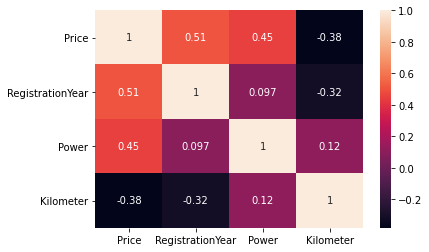

In [21]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True);

Можно заметить, что цена неплохо коррелирует с годом регистрации и кол-вом лошадиных сил. Люди хотят себе купить машины помощнее и поновее. 

Посмотрим, что получилось по итогу после всях манипуляций

In [22]:
info_func(df)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249551 entries, 0 to 249550
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             249551 non-null  int64 
 1   VehicleType       249551 non-null  object
 2   RegistrationYear  249551 non-null  int64 
 3   Gearbox           249551 non-null  object
 4   Power             249551 non-null  int64 
 5   Model             249551 non-null  object
 6   Kilometer         249551 non-null  int64 
 7   FuelType          249551 non-null  object
 8   Brand             249551 non-null  object
 9   Repaired          249551 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.0+ MB
None

               Price  RegistrationYear          Power      Kilometer
count  249551.000000      249551.00000  249551.000000  249551.000000
mean     5066.256661        2003.10044     123.298532  127158.957488
std      4650.946172           6.30998     

In [23]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)

### Вывод по главе
В ходе обработки данных было потеряно около 33% от первоначального объема данных. Были обработаны:
* пропуски
* аномальные значения
* дубликаты <br /> 

Также стало понятно, что цена наиболее всего зависит от года регистрации и кол-ва лошадиных сил машины.

## Обучение моделей

Обозначаем какие признаки категориальные, а какие числовые. Так же, последующие операции будем проводить уже над копией датасета.

In [24]:
category = ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType', 'RegistrationYear', 'Repaired']
number = ['Power', 'Kilometer']

In [25]:
df_2 = df.copy()
df_2.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no_info
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Делим данные на признаки и цель

In [26]:
features=df_2.drop(['Price'],axis=1)
target=df_2['Price']

Делим на обучающую и тестовую выборки

In [27]:
train_features, test_features, train_target, test_target = train_test_split(features,target, test_size=0.25, random_state=RND_ST)

In [28]:
display(train_features)
test_features

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
233638,sedan,1995,auto,102,3er,150000,petrol,bmw,no
222155,small,2013,manual,80,micra,30000,petrol,nissan,no_info
125960,sedan,1999,manual,101,astra,150000,petrol,opel,no
66403,sedan,2006,auto,272,x_reihe,100000,petrol,bmw,no
87186,other,2016,manual,70,corsa,50000,gasoline,opel,no
...,...,...,...,...,...,...,...,...,...
85412,small,2008,manual,86,ibiza,150000,petrol,seat,no
133249,bus,1997,auto,174,galaxy,150000,lpg,ford,yes
130333,small,1996,manual,45,corsa,125000,petrol,opel,no
77285,wagon,2007,manual,170,a4,150000,gasoline,audi,no_info


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
165936,other,2016,auto,105,3er,150000,petrol,bmw,no
160876,small,2000,manual,75,justy,150000,petrol,subaru,no
213062,sedan,2012,manual,140,golf,150000,gasoline,volkswagen,no
90210,wagon,2004,manual,122,v40,150000,petrol,volvo,no_info
117688,other,2007,manual,65,unknown,125000,cng,fiat,yes
...,...,...,...,...,...,...,...,...,...
131438,sedan,1998,manual,105,3er,150000,petrol,bmw,yes
86744,coupe,2003,manual,143,c_klasse,150000,gasoline,mercedes_benz,no
3777,sedan,2003,manual,170,3er,125000,petrol,bmw,no
82878,small,2000,unknown,54,fortwo,150000,petrol,smart,no


Преобразовываем категориальные признаки с помощью OHE 

In [29]:
train_features=train_features.reset_index(drop=True)
test_features=test_features.reset_index(drop=True)

In [30]:
ohe = OneHotEncoder(handle_unknown='error', drop='first')

In [31]:
ohe.fit(train_features[category])
ohe_train = pd.DataFrame(ohe.transform(train_features[category]).toarray())
ohe_test = pd.DataFrame(ohe.transform(test_features[category]).toarray())
ohe_train.columns=ohe.get_feature_names_out()
ohe_test.columns=ohe.get_feature_names_out()
final_train = train_features.join(ohe_train)
final_test = test_features.join(ohe_test)
final_train.drop(category, axis=1, inplace=True)
final_test.drop(category, axis=1, inplace=True)
display(final_train.head())
final_test.head()

,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,...,RegistrationYear_2009,RegistrationYear_2010,RegistrationYear_2011,RegistrationYear_2012,RegistrationYear_2013,RegistrationYear_2014,RegistrationYear_2015,RegistrationYear_2016,Repaired_no_info,Repaired_yes
0,102,150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,80,30000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,101,150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,272,100000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,70,50000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,...,RegistrationYear_2009,RegistrationYear_2010,RegistrationYear_2011,RegistrationYear_2012,RegistrationYear_2013,RegistrationYear_2014,RegistrationYear_2015,RegistrationYear_2016,Repaired_no_info,Repaired_yes
0,105,150000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,75,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,140,150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,122,150000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,65,125000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Преобразовываем категориальные признаки с помощью OrdinalEncoder

In [32]:
encoder = OrdinalEncoder()

In [33]:
encoder.fit(train_features[category])
train_features_ord = train_features.copy()
test_features_ord = test_features.copy()
train_features_ord[category]= encoder.transform(train_features[category])
test_features_ord[category]= encoder.transform(test_features[category])
display(train_features_ord.head())
test_features_ord.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,4.0,25.0,0.0,102,11.0,150000,6.0,2.0,0.0
1,5.0,43.0,1.0,80,151.0,30000,6.0,23.0,1.0
2,4.0,29.0,1.0,101,42.0,150000,6.0,24.0,0.0
3,4.0,36.0,0.0,272,241.0,100000,6.0,2.0,0.0
4,3.0,46.0,1.0,70,83.0,50000,2.0,24.0,0.0


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,3.0,46.0,0.0,105,11.0,150000,6.0,2.0,0.0
1,5.0,30.0,1.0,75,127.0,150000,6.0,34.0,0.0
2,4.0,42.0,1.0,140,116.0,150000,2.0,38.0,0.0
3,7.0,34.0,1.0,122,229.0,150000,6.0,39.0,1.0
4,3.0,37.0,1.0,65,227.0,125000,0.0,9.0,2.0


Скалируем числовые признаки после OHE

In [34]:
scaler = StandardScaler()
scaler.fit(final_train[number])
train_features_scaled = final_train.copy()
test_features_scaled = final_test.copy()
train_features_scaled[number] = scaler.transform(train_features_scaled[number])
test_features_scaled[number] = scaler.transform(test_features_scaled[number])
display(train_features_scaled.shape)
display(test_features_scaled.shape)

(187159, 353)

(62387, 353)

Скалируем числовые признаки после OrdinalEncoder

In [35]:
scaler_2 = StandardScaler()
scaler_2.fit(train_features_ord[number])
train_features_scaled_2 = train_features_ord.copy()
test_features_scaled_2 = test_features_ord.copy()
train_features_scaled_2[number] = scaler_2.transform(train_features_scaled_2[number])
test_features_scaled_2[number] = scaler_2.transform(test_features_scaled_2[number])
display(train_features_scaled_2.shape)
display(test_features_scaled_2.shape)
display(train_features_scaled_2.head())
test_features_scaled_2.head()

(187159, 9)

(62387, 9)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,4.0,25.0,0.0,-0.363375,11.0,0.612766,6.0,2.0,0.0
1,5.0,43.0,1.0,-0.740038,151.0,-2.602318,6.0,23.0,1.0
2,4.0,29.0,1.0,-0.380496,42.0,0.612766,6.0,24.0,0.0
3,4.0,36.0,0.0,2.547207,241.0,-0.726852,6.0,2.0,0.0
4,3.0,46.0,1.0,-0.911249,83.0,-2.066470,2.0,24.0,0.0


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,3.0,46.0,0.0,-0.312012,11.0,0.612766,6.0,2.0,0.0
1,5.0,30.0,1.0,-0.825644,127.0,0.612766,6.0,34.0,0.0
2,4.0,42.0,1.0,0.287226,116.0,0.612766,2.0,38.0,0.0
3,7.0,34.0,1.0,-0.020954,229.0,0.612766,6.0,39.0,1.0
4,3.0,37.0,1.0,-0.996854,227.0,-0.057043,0.0,9.0,2.0


### Вывод по главе
* категориальные признаки переведены
* числовые признаки проскалированы
* получены тренировочные и тестовые выборки 

## Анализ моделей

Расчет RMSE

In [36]:
def rmse(target, predicted):
    return mean_squared_error(target, predicted) ** 0.5

Нашел в инете очень классную визуализацию предсказаний модели - позаимствовал - буду применять.

In [37]:
def illustration(test,predict):
    rmse = mean_squared_error(test,predict)
    mae = mean_absolute_error(test,predict)
    plt.figure(figsize=(10, 5))
    pd.Series(predict).hist(bins=50, alpha=0.8)
    pd.Series(test).hist(bins=50, alpha=0.8)
    plt.legend(['Предсказанные значения', 'Истинные значения'])
    plt.title('График распределения предсказанных и истинных значениий', y=1.05)
    plt.xlabel('Предсказанные / Истинные значения')
    plt.ylabel('Количество')
    plt.subplot()
    
    plt.figure(figsize=(10, 10))
    plt.plot(predict,test,'o', alpha=0.5)
    plt.xlim(-5000,25000)
    plt.ylim(-5000,25000)
    plt.plot([-10000,25000],[-10000,25000],'--y', linewidth=2)
    plt.title('График отношения предсказанных значений к истинным значениям', y=1.05)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show()

Для начала проверим константную модель DummyRegressor

In [53]:
%%time

model_test = DummyRegressor(strategy = "median")
model_test.fit(train_features_scaled, train_target)

CPU times: user 4.32 ms, sys: 131 µs, total: 4.46 ms
Wall time: 3.12 ms


DummyRegressor(strategy='median')

In [54]:
%%time

predict_test = model_test.predict(train_features_scaled)

CPU times: user 1.17 ms, sys: 418 µs, total: 1.59 ms
Wall time: 687 µs


MAE: 3462.621541042643
RMSE: 4923.040117271563


/tmp/ipykernel_294/2670033738.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot()


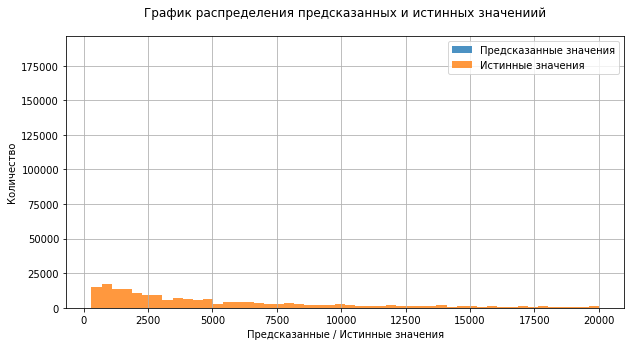

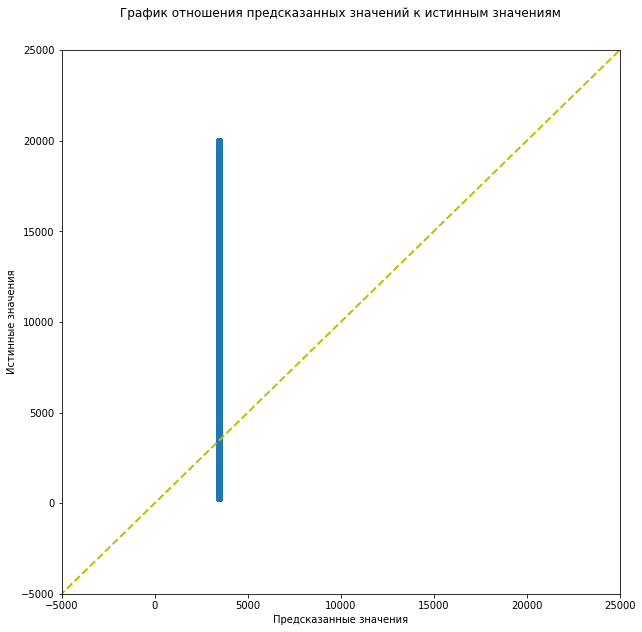

In [55]:
rmse_test = rmse(train_target, predict_test)
mae_test = mean_absolute_error(train_target, predict_test)
print('MAE:',mae_test)
print('RMSE:',rmse_test)
illustration(train_target, predict_test)

Статичная модель не дает нужного результата

Попробуем LinearRegression

In [56]:
%%time

model_1 = LinearRegression()
model_1.fit(train_features_scaled, train_target)

CPU times: user 29.7 s, sys: 37.1 s, total: 1min 6s
Wall time: 1min 6s


LinearRegression()

In [57]:
%%time

predict_1 = model_1.predict(train_features_scaled)

CPU times: user 179 ms, sys: 38.4 ms, total: 217 ms
Wall time: 201 ms


MAE: 1502.5429296176349
RMSE: 2141.494945961385


/tmp/ipykernel_294/2670033738.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot()


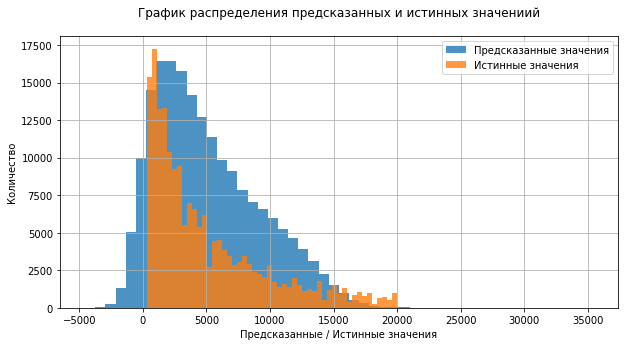

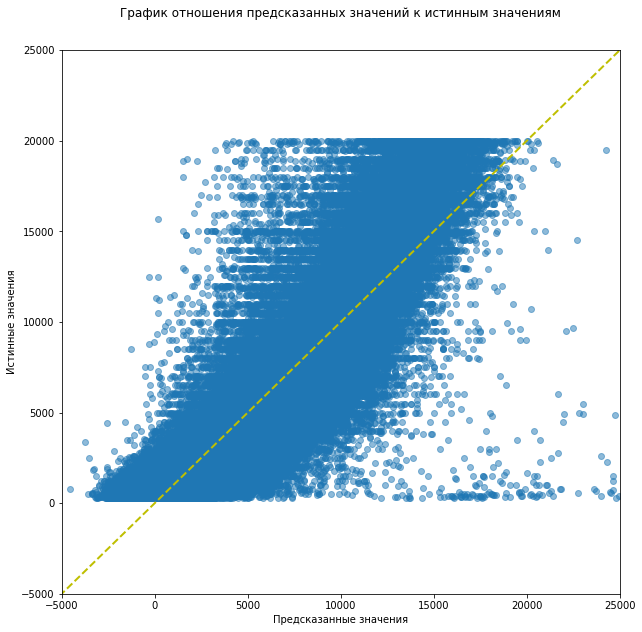

In [58]:
rmse_1 = rmse(train_target, predict_1)
mae_1 = mean_absolute_error(train_target, predict_1)
print('MAE:',mae_1)
print('RMSE:',rmse_1)
illustration(train_target, predict_1)

Мы достигли нужного результата, пропробуем его улучшить

SGDRegressor

In [44]:
%%time

parameters_2={'alpha': np.logspace(-4, 0, 5)}

model_2_test=SGDRegressor(loss = 'squared_epsilon_insensitive', random_state = RND_ST, learning_rate= 'adaptive')
grid_2=GridSearchCV(model_2_test, parameters_2, scoring='neg_mean_squared_error')
grid_2.fit(train_features_scaled_2, train_target)

grid_2.best_params_

CPU times: user 2min 23s, sys: 2.37 s, total: 2min 25s
Wall time: 2min 26s


{'alpha': 0.0001}

Лучшие параметры для SGFRegressor полученные с помощью GridSearchCV: 'alpha': 0.0001

In [59]:
%%time

model_2 = SGDRegressor(loss = 'squared_epsilon_insensitive', random_state = RND_ST, learning_rate= 'adaptive', alpha=0.0001)
model_2.fit(train_features_scaled, train_target)

CPU times: user 22.3 s, sys: 196 ms, total: 22.5 s
Wall time: 22.5 s


SGDRegressor(learning_rate='adaptive', loss='squared_epsilon_insensitive',
             random_state=12345)

In [60]:
%%time

predict_2 = model_2.predict(train_features_scaled)

CPU times: user 139 ms, sys: 65.2 ms, total: 204 ms
Wall time: 167 ms


MAE: 1505.0685220428502
RMSE: 2144.1146350198974


/tmp/ipykernel_294/2670033738.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot()


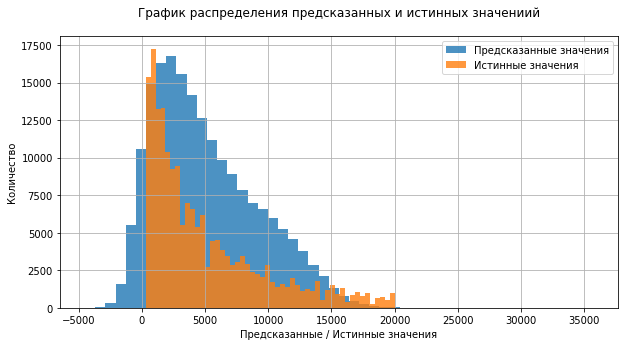

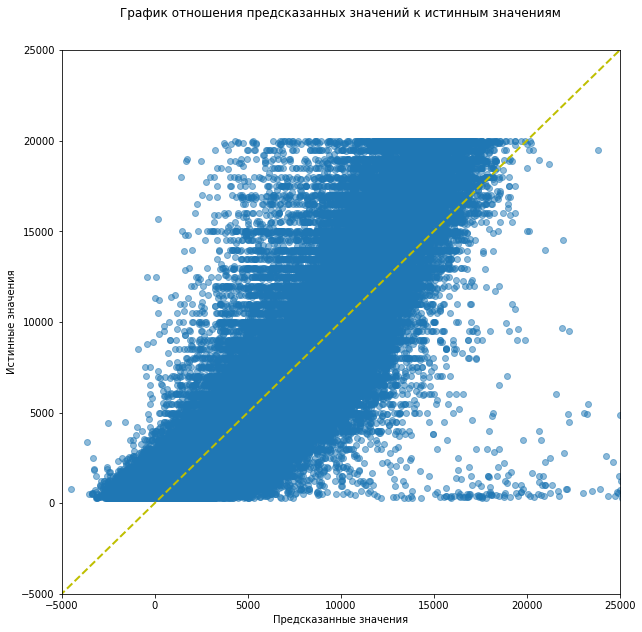

In [61]:
rmse_2 = rmse(train_target, predict_2)
mae_2 = mean_absolute_error(train_target, predict_2)
print('MAE:',mae_2)
print('RMSE:',rmse_2)
illustration(train_target, predict_2)

ElasticNet (его конечно было глупо использовать - данных у нас много, но ради интереса)

In [ ]:
%%time

parameters_3 = {'alpha': np.arange(0.1, 1.0, 0.1), 'l1_ratio': np.arange(0.1, 1.0, 0.1)}

model_3_test = ElasticNet(random_state = RND_ST)
grid_3 = GridSearchCV(model_3_test, parameters_3)
grid_3.fit(train_features_scaled, train_target)

grid_3.best_params_

Лучшие параметры для ElasticNet полученные с помощью GridSearchCV: 'alpha': 0.01, 'l1_ratio': 0.9

In [62]:
%%time

model_3 = ElasticNet(random_state = RND_ST, alpha = 0.1, l1_ratio = 0.9)
model_3.fit(train_features_scaled, train_target)

CPU times: user 1min 29s, sys: 2min 16s, total: 3min 46s
Wall time: 3min 46s


ElasticNet(alpha=0.1, l1_ratio=0.9, random_state=12345)

In [63]:
%%time

predict_3 = model_3.predict(train_features_scaled)

CPU times: user 196 ms, sys: 23.2 ms, total: 219 ms
Wall time: 275 ms


MAE: 1705.5215681584857
RMSE: 2431.1781250881577


/tmp/ipykernel_294/2670033738.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot()


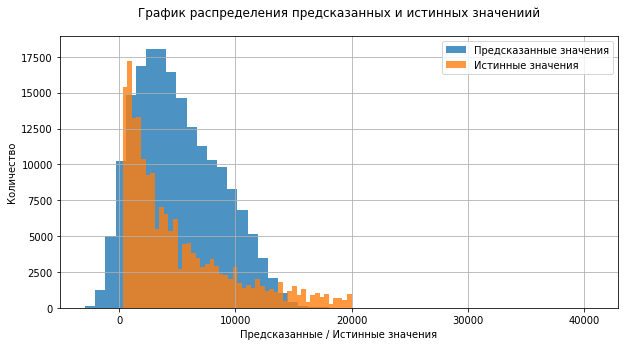

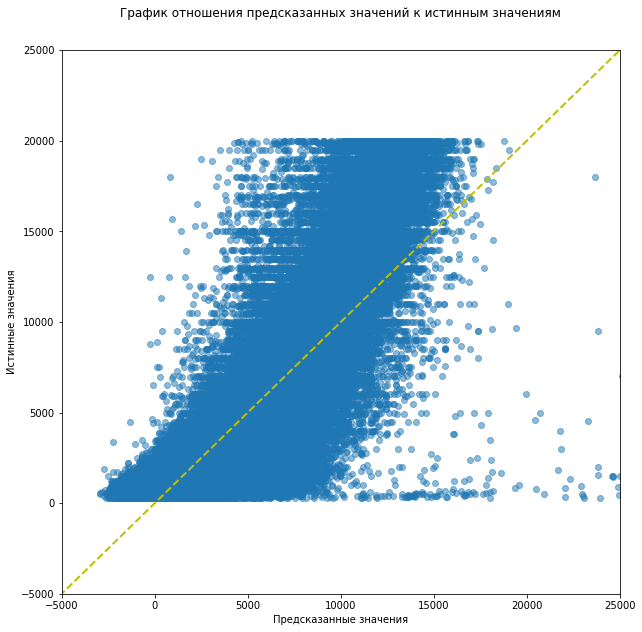

In [64]:
rmse_3 = rmse(train_target, predict_3)
mae_3 = mean_absolute_error(train_target, predict_3)
print('MAE:',mae_3)
print('RMSE:',rmse_3)
illustration(train_target, predict_3)

И самое интересное LGBMRegressor

In [ ]:
%%time

parameters_4={'learning_rate': np.logspace(-3, 0, 5), 'n_estimators': range(20, 61, 20), 'num_leaves': range(20, 41, 10)}

model_4_test=LGBMRegressor(boosting_type='gbdt', random_state=RND_ST, objective='rmse')
grid_4=GridSearchCV(model_4_test, parameters_4, scoring='neg_mean_squared_error')
grid_4.fit(train_features_scaled_2, train_target)

grid_4.best_params_

Лучшие параметры для LGBMRegressor полученные с помощью GridSearchCV: n_estimators=60, learning_rate=0.2, num_leaves=40.

In [65]:
%%time

model_4=LGBMRegressor(boosting_type='gbdt', random_state=RND_ST, objective='rmse', n_estimators=60, learning_rate=0.2, num_leaves=40)
model_4.fit(train_features_scaled_2, train_target, eval_set=(train_features_scaled_2,train_target), verbose = 10)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 2041.36
[20]	training's rmse: 1776.52
[30]	training's rmse: 1698.23
[40]	training's rmse: 1657.84
[50]	training's rmse: 1630.41
[60]	training's rmse: 1608.33
CPU times: user 1min 40s, sys: 59.8 ms, total: 1min 40s
Wall time: 1min 40s


LGBMRegressor(learning_rate=0.2, n_estimators=60, num_leaves=40,
              objective='rmse', random_state=12345)

In [66]:
%%time

predict_4 = model_4.predict(train_features_scaled_2)

CPU times: user 901 ms, sys: 0 ns, total: 901 ms
Wall time: 895 ms


MAE: 1054.9333016215792
RMSE: 1608.3307742486318


/tmp/ipykernel_294/2670033738.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot()


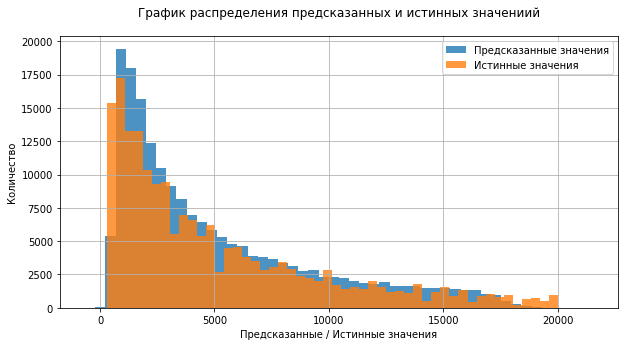

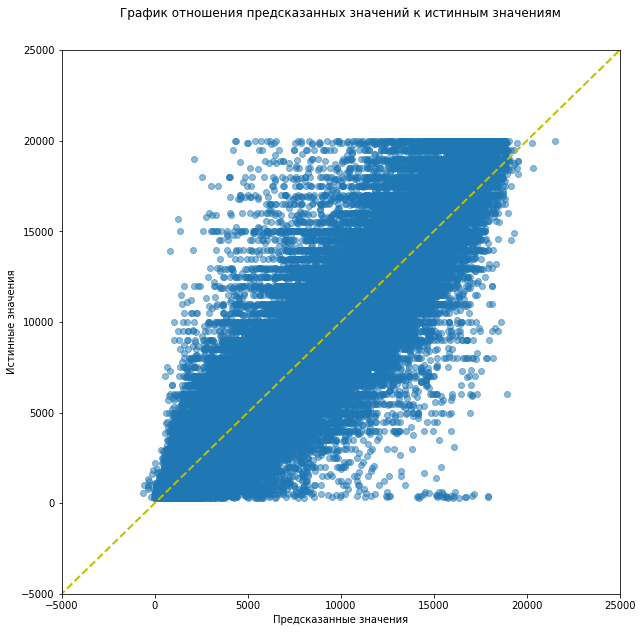

In [67]:
rmse_4 = rmse(train_target, predict_4)
mae_4 = mean_absolute_error(train_target, predict_4)
print('MAE:',mae_4)
print('RMSE:',rmse_4)
illustration(train_target, predict_4)

## Проверка моделей на тестовой выборке

Лучшей моделью оказалась LGBMRegressor с параметрами: n_estimators=60, learning_rate=0.2, num_leaves=40. Проверим ее на тестовой выборке.

In [68]:
%%time

model_4=LGBMRegressor(boosting_type='gbdt', random_state=RND_ST, objective='rmse', n_estimators=60, learning_rate=0.2, num_leaves=40)
model_4.fit(train_features_scaled_2, train_target, eval_set=(train_features_scaled_2,train_target), verbose = 10)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 2041.36
[20]	training's rmse: 1776.52
[30]	training's rmse: 1698.23
[40]	training's rmse: 1657.84
[50]	training's rmse: 1630.41
[60]	training's rmse: 1608.33
CPU times: user 2min 17s, sys: 1.42 s, total: 2min 19s
Wall time: 2min 19s


LGBMRegressor(learning_rate=0.2, n_estimators=60, num_leaves=40,
              objective='rmse', random_state=12345)

In [69]:
%%time

predict_4 = model_4.predict(test_features_scaled_2)

CPU times: user 319 ms, sys: 0 ns, total: 319 ms
Wall time: 288 ms


MAE: 1077.9051707808576
RMSE: 1652.809562651203


/tmp/ipykernel_294/2670033738.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot()


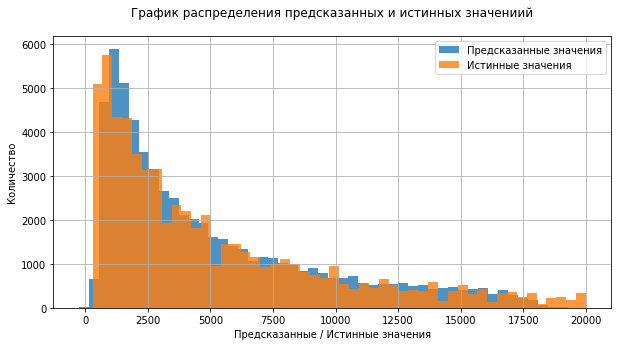

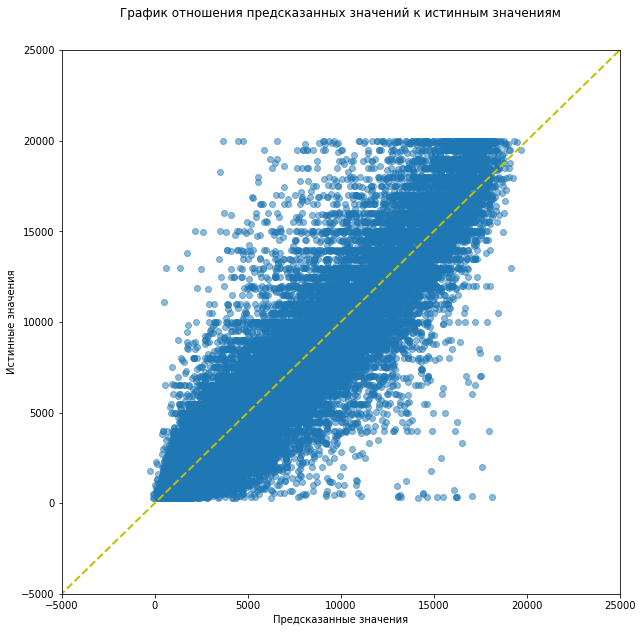

In [70]:
rmse_4 = rmse(test_target, predict_4)
mae_4 = mean_absolute_error(test_target, predict_4)
print('MAE:',mae_4)
print('RMSE:',rmse_4)
illustration(test_target, predict_4)

## Общий вывод
Качество исходных данных заметно повысилось благодаря: обработке пропусков, аномальных значений, дубликатов. <br /> 

Категориальные признаки были переведены, числовые признаки проскалированы и получены тренировочные и тестовые выборки. <br /> 

Результаты моделей на тренировочной выборке с использованием наилучших параметров полученных благодаря GridSearchCV:
* модель DummyRegressor: RMSE: 4923.04, время обучения: 3.12 ms, время предсказывания: 687 µs
* модель LinearRegression: RMSE: 2141.49, время обучения: 1min 6s, время предсказывания: 201 ms
* модель SGDRegressor: RMSE: 2144.11, время обучения: 22.5 s, время предсказывания: 167 ms
* модель ElasticNet: RMSE: 2431.17, время обучения: 3min 46s, время предсказывания: 275 ms
* модель LGBMRegressor: RMSE: 1608.33, время обучения: 1min 40s, время предсказывания: 895 ms

Наилучший результат достигается при модели LGBMRegressor, у которого: RMSE на тестовой выборке: 1652.81, модель обучается за 2 минуты 19 секунды и предсказывает за 288 ms. Что удовлетворяет поставленной задаче.